In [35]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

%matplotlib inline

In [36]:
# Convolutional Neural Network
# keras functional API
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.set_random_seed(1)

In [37]:
ALPHA = 0.2  # Triplet Loss Parameter

imhight = 128
imwidth = 128

# ネットワーク構造の定義
低層を共有

In [38]:
# shared Layer
shared_Conv1= Conv2D(64, (4,4), padding='same', activation='relu')
shared_MP1= MaxPooling2D(pool_size=(2, 2))

In [39]:
# anchor 
a_in = Input(shape = (imhight, imwidth,3), name='anchor_input')
conv1 = shared_Conv1(a_in)
pool1 = shared_MP1(conv1)
conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dense = Dense(20, activation='relu')(pool2)
a_emb = Flatten(name='anchor_output')(dense)

In [40]:
# positive sample
p_in = Input(shape = (imhight, imwidth,3), name='positive_input')
conv1 =  shared_Conv1(p_in)
pool1 = shared_MP1(conv1)
conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# conv3 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool2)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dense = Dense(20, activation='relu')(pool2)
p_emb = Flatten(name='positive_output')(dense)

In [41]:
# negative sample
n_in = Input(shape = (imhight, imwidth,3))
conv1 =  shared_Conv1(n_in)
pool1 = shared_MP1(conv1)
conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dense = Dense(20, activation='relu')(pool2)
n_emb = Flatten(name='negative_output')(dense)

## triplet loss計算用のLayerインスタンスをLayerクラスを継承して作成
tensorflow --> numpy ×(error)<br>
numpy --> tensorflow ○<br>
triplet_lossの計算には **tensorflowの書式** を用いる。

In [42]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

・ numpy配列のリスト、**[a_emb,p_emb,n_emb]のtriplet**を入力とするレイヤーを定義<br>
・ LayerインスタンスとしてModelの中に組み込む<br>
・ Inputインスタンスを指定すると、emb(埋込)までを認識してくれる。

In [43]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

## ネットワーク構造の可視化

In [72]:
# 画像として出力
plot_model(tripletNet, show_shapes=True,  show_layer_names=False, to_file='tripletNet.png')

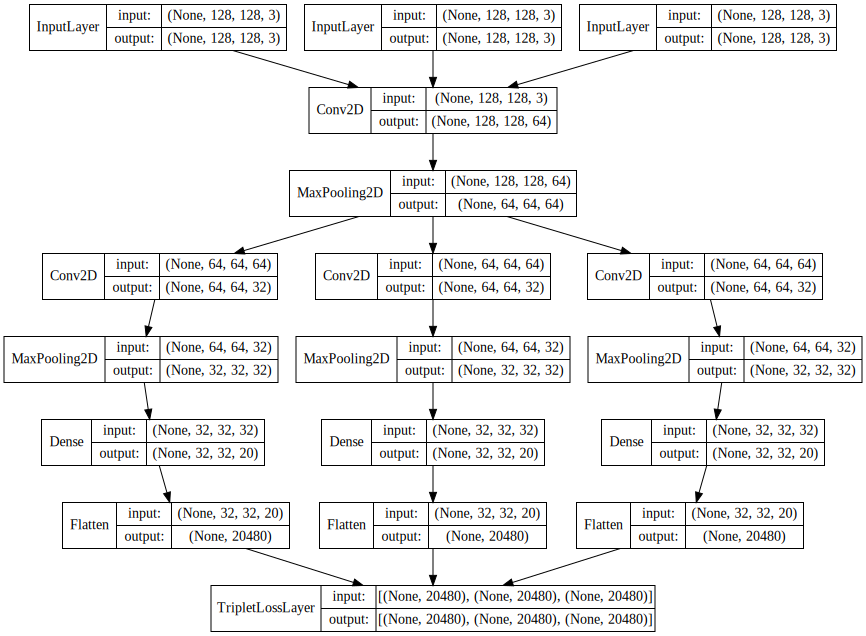

In [73]:
# Jupyter上に構造を出力
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(tripletNet, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

## 動作確認

In [46]:
# sample data
# data_gen.pyからtriplet_generatorを読み込んでsample生成
from data_gen import triplet_generator
generator = triplet_generator()

### モデルのコンパイル

In [47]:
tripletNet.compile(loss=None, optimizer='adam')
# tripletNet.fit_generator(generator=generator, epochs=10, steps_per_epoch=100)

/home/inouelab/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  """Entry point for launching an IPython kernel.


In [48]:
import numpy as np
a_batch = np.random.rand(4, 128, 128, 3)
p_batch = np.random.rand(4, 128, 128, 3)
n_batch = np.random.rand(4, 128, 128, 3)

x = [a_batch,p_batch,n_batch]

In [49]:
# tripletNet=tripletNet.fit(x, epochs=1, steps_per_epoch=100)

In [50]:
np.array(x).shape

(3, 4, 128, 128, 3)

## 簡単なデータセットで実験してみる
いきなりDeepFashionのデータを扱うのではなく、より簡単な画像で実験する。<br>
<del>アニメのキャラ画像でやる。</del><br>
乃木坂の画像でやる。

## 乃木坂の画像をnumpy配列に変更。

In [51]:
import os
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img # keras library for image to array

In [52]:
# check dataset
os.listdir('nogi_imgs/') 

['shiraishi', 'test', '.DS_Store', 'akimoto', 'the_others', 'ikuta', 'nishino']

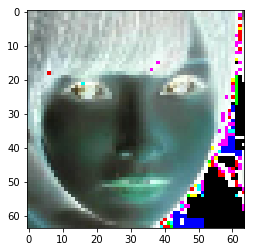

In [53]:
# load_imgを用いるとRGBがおかしくなる？
temp_img = load_img('./nogi_imgs/shiraishi/inputImage2_0.png', target_size=(64,64))
temp_img_array  = img_to_array(temp_img)
plt.imshow(temp_img_array)
plt.show()

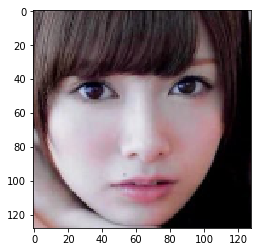

In [54]:
img = plt.imread('./nogi_imgs/shiraishi/inputImage2_0.png')
plt.imshow(img)
plt.show()

In [55]:
type(img)

numpy.ndarray

In [56]:
dir_path = './nogi_imgs/shiraishi/'
others_path = './nogi_imgs/akimoto/'
files = [f for f in sorted(os.listdir(dir_path))]
other_files = [o for o in sorted(os.listdir(others_path))]

同一人物の画像のペアを乱数で生成し、そこに別の人物の画像を加え**triplet**を構成する。<br>
**triplet = [anchor, positive, negative]**が想定されているのでそのようにリストを作成する。

In [57]:
# get anchor and positive image　
pair = np.random.randint(0,len(files),2)
anchor = plt.imread('{0}{1}'.format(dir_path,files[pair[0]]))
positive = plt.imread('{0}{1}'.format(dir_path,files[pair[1]]))

In [58]:
# get negative image
nega_idx = np.random.randint(len(other_files))
negative = plt.imread('{}/{}'.format(others_path,other_files[nega_idx]))

In [59]:
# get triplet
triplet = [anchor, positive, negative] 

## 可視化によるtripletの確認

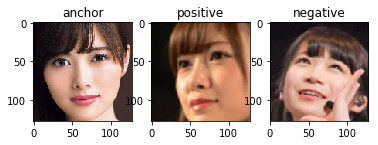

In [60]:
plt.subplot(1,3,1)
plt.imshow(triplet[0])
plt.title('anchor')
plt.subplot(1,3,2)
plt.imshow(triplet[1])
plt.title('positive')
plt.subplot(1,3,3)
plt.imshow(triplet[2])
plt.title('negative')
plt.show()

tripletが生成できていることが判ったため、大量に生成する。

In [61]:
# only name directories
names = [name for name in sorted(os.listdir('./nogi_imgs/'))]
names.remove('.DS_Store')
names.remove('test')
names.remove('the_others')

names

['akimoto', 'ikuta', 'nishino', 'shiraishi']

In [62]:
dir_pathes = []
for name in names:
    dir_pathes.append('./nogi_imgs/{}/'.format(name))

In [63]:
dir_pathes

['./nogi_imgs/akimoto/',
 './nogi_imgs/ikuta/',
 './nogi_imgs/nishino/',
 './nogi_imgs/shiraishi/']

## 各人100個分のtripletを生成。

In [64]:
# method for visualization
def plot_triplet(triplet): 
    plt.subplot(1,3,1)
    plt.imshow(triplet[0])
    plt.title('anchor')
    plt.subplot(1,3,2)
    plt.imshow(triplet[1])
    plt.title('positive')
    plt.subplot(1,3,3)
    plt.imshow(triplet[2])
    plt.title('negative')
    plt.show()

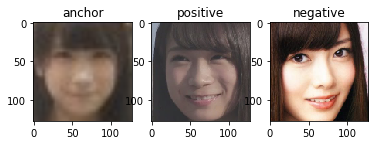

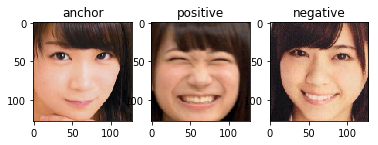

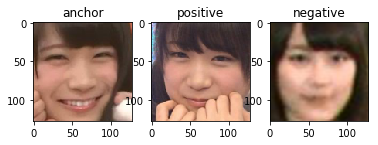

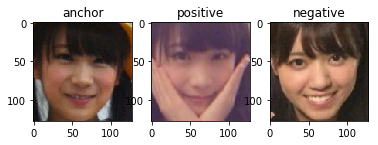

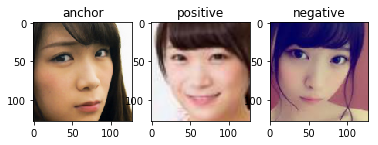

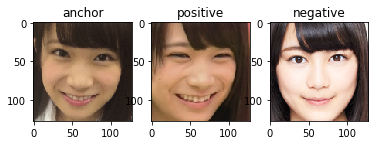

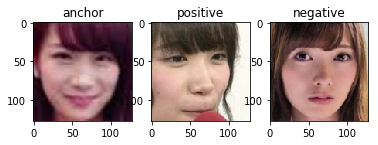

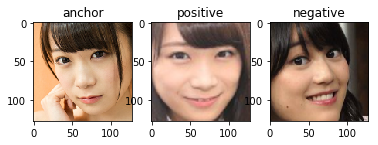

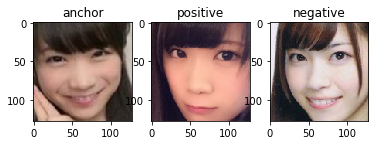

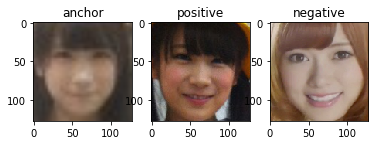

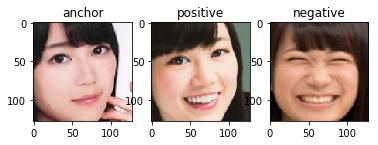

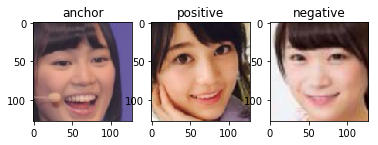

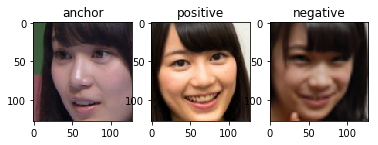

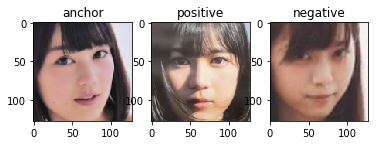

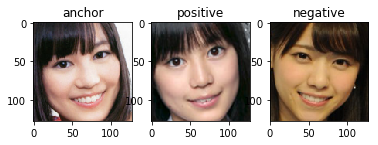

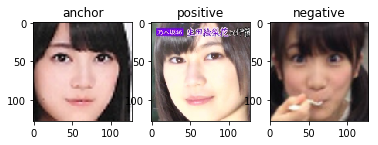

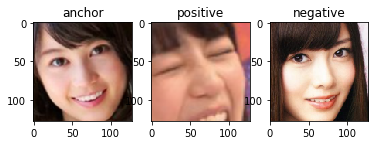

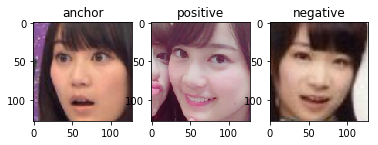

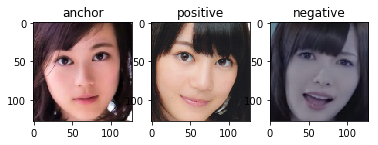

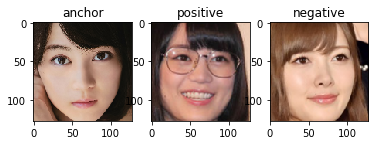

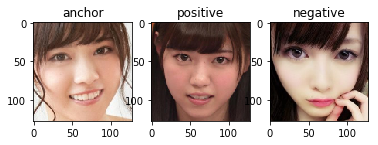

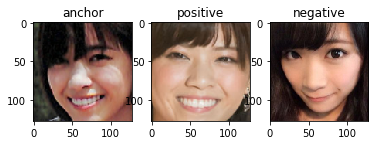

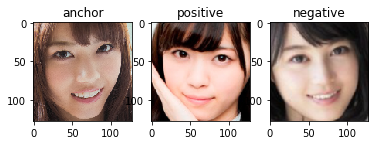

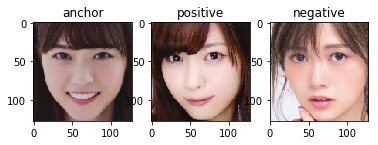

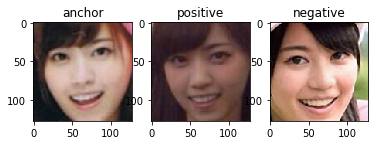

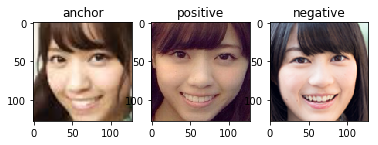

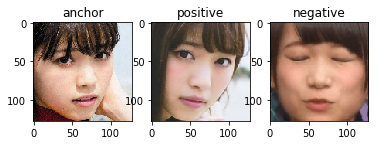

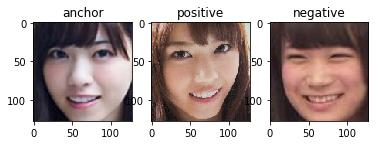

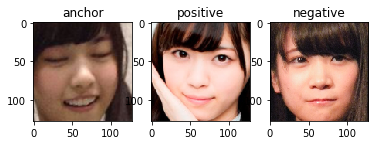

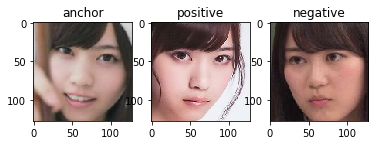

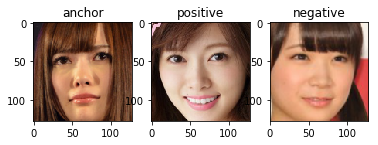

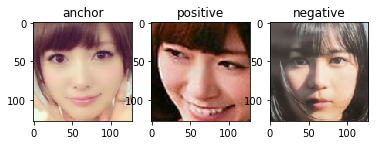

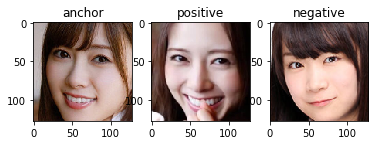

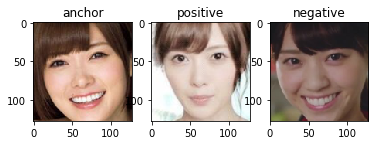

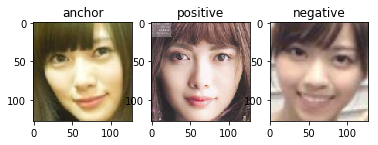

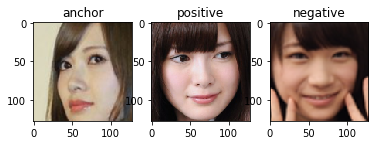

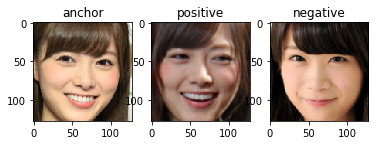

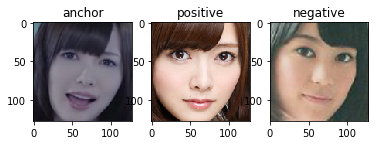

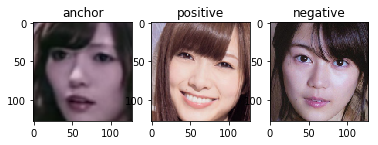

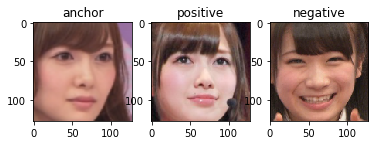

In [65]:
triplets = []
for i in range(len(dir_pathes)):
    # set the files of anchor and positive images
    anc_pos_files = [f for f in sorted(os.listdir(dir_pathes[i]))]
    anc_pos_files.remove('.DS_Store')
    for iteration in range(10):

        # set the files of negative images
        j = random.choice([num for num in range(len(dir_pathes)) if num not in [i]])
        nega_files = [o for o in sorted(os.listdir(dir_pathes[j]))]
        nega_files.remove('.DS_Store')

        # get anchor and positive images as numpy array
        pair = np.random.randint(0,len(anc_pos_files),2)
        anchor = plt.imread('{0}{1}'.format(dir_pathes[i],anc_pos_files[pair[0]]))
        positive = plt.imread('{0}{1}'.format(dir_pathes[i],anc_pos_files[pair[1]]))   

        # get negative images as numpy array
        nega_idx = np.random.randint(len(nega_files))
        negative = plt.imread('{0}{1}'.format(dir_pathes[j],nega_files[nega_idx]))

        # make triplet
        triplet = [anchor, positive, negative]
        triplets.append(triplet)
        
        # visualization
        plot_triplet(triplet)

### triplets を list -> **numpy array** にして扱えるようにする。

In [66]:
triplets = np.array(triplets)
print(triplets.shape)

(40, 3, 128, 128, 3)


In [67]:
# 列を切り出してanchorのテンソル、positiveのテンソル、negativeのテンソルにする。
# 以下はanchorのテンソルの形を確認している。
triplets[:,0].shape

(40, 128, 128, 3)

In [68]:
# tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)
tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)

print('save the architecture of a model')
json_string = tripletNet.to_json()
open(os.path.join(f_model,'triplet_model.json'), 'w').write(json_string)
yaml_string = tripletNet.to_yaml()
open(os.path.join(f_model,'triplet_model.yaml'), 'w').write(yaml_string)
print('save weights')
tripletNet.save_weights(os.path.join(f_model,'triplet_model_weights.hdf5'))

Epoch 1/10
100/100 [==============================] - 251s 3s/step - loss: 104.7882
Epoch 2/10
100/100 [==============================] - 251s 3s/step - loss: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 251s 3s/step - loss: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 251s 3s/step - loss: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 252s 3s/step - loss: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 251s 3s/step - loss: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 252s 3s/step - loss: 0.0000e+00
Epoch 8/10
100/100 [==============================] - 251s 3s/step - loss: 0.0000e+00
Epoch 9/10
100/100 [==============================] - 252s 3s/step - loss: 0.0000e+00
Epoch 10/10
100/100 [==============================] - 252s 3s/step - loss: 0.0000e+00
save the architecture of a model


NameError: name 'model' is not defined

In [70]:
f_model = './model'
print('save the architecture of a model')
json_string = tripletNet.to_json()
open(os.path.join(f_model,'triplet_model.json'), 'w').write(json_string)
yaml_string = tripletNet.to_yaml()
open(os.path.join(f_model,'triplet_model.yaml'), 'w').write(yaml_string)
print('save weights')
tripletNet.save_weights(os.path.join(f_model,'triplet_model_weights.hdf5'))

save the architecture of a model
save weights


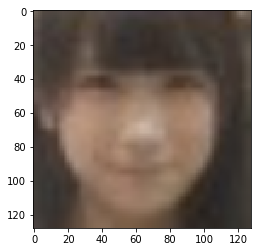

In [75]:
plt.imshow(triplets[0][0])

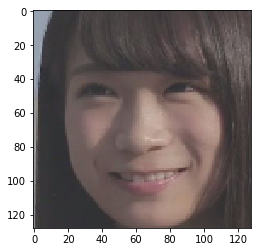

In [76]:
plt.imshow(triplets[0][1])

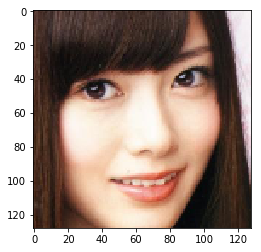

In [77]:
plt.imshow(triplets[0][2])